# Cacao Contracts Exploratory Analysis

This notebook analyzes two cacao contract series (CC and C) to identify patterns, trends, seasonality, and relationships between the contracts.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [52]:
# Load both datasets
cc_data = pd.read_csv('dati_cacao_CC.csv')
c_data = pd.read_csv('dati_cacao_C.csv')

print("CC Contract Data Shape:", cc_data.shape)
print("C Contract Data Shape:", c_data.shape)
print("\nCC Contract Columns:", cc_data.columns.tolist())
print("C Contract Columns:", c_data.columns.tolist())

# Handle column name differences
if 'Date' in c_data.columns:
    c_data = c_data.rename(columns={'Date': 'date'})

# Note: Currency assumptions based on price levels and market knowledge
print("\n*** DATA STRUCTURE AND CURRENCY INFORMATION ***")
print("CC Contract: Full OHLCV data with volume - Priced in USD")
print("C Contract: Only close prices available - Priced in GBP")
print("Will convert C contract prices to USD using USD/GBP exchange rates")

CC Contract Data Shape: (4047, 7)
C Contract Data Shape: (3723, 2)

CC Contract Columns: ['date', 'open', 'high', 'low', 'close', 'contract_code', 'VOLUME']
C Contract Columns: ['Date', 'close']

*** DATA STRUCTURE AND CURRENCY INFORMATION ***
CC Contract: Full OHLCV data with volume - Priced in USD
C Contract: Only close prices available - Priced in GBP
Will convert C contract prices to USD using USD/GBP exchange rates


In [53]:
# Convert date columns to datetime
cc_data['date'] = pd.to_datetime(cc_data['date'])
c_data['date'] = pd.to_datetime(c_data['date'])

# Sort by date
cc_data = cc_data.sort_values('date').reset_index(drop=True)
c_data = c_data.sort_values('date').reset_index(drop=True)

# Get USD/GBP exchange rate data
print("Downloading USD/GBP exchange rate data...")
try:
    # Get historical USD/GBP data from 2007 to present
    usdgbp = yf.download('GBPUSD=X', start='2007-01-01', end='2025-12-31', progress=False)
    usdgbp = usdgbp[['Close']].reset_index()
    usdgbp.columns = ['date', 'usdgbp_rate']
    usdgbp['date'] = pd.to_datetime(usdgbp['date'])
    
    print(f"Downloaded {len(usdgbp)} exchange rate observations")
    print(f"FX data range: {usdgbp['date'].min()} to {usdgbp['date'].max()}")
    
    # Merge FX data with C contract data
    c_data = pd.merge(c_data, usdgbp, on='date', how='left')
    
    # Forward fill missing FX rates (for weekends/holidays)
    c_data['usdgbp_rate'] = c_data['usdgbp_rate'].fillna(method='ffill')
    
    # Convert GBP prices to USD
    c_data['close_usd'] = c_data['close'] * c_data['usdgbp_rate']
    c_data['close_original_gbp'] = c_data['close'].copy()  # Keep original GBP prices
    
    # Replace close with USD version for analysis
    c_data['close'] = c_data['close_usd']
    
    print(f"Successfully converted C contract prices from GBP to USD")
    print(f"Sample conversion: {c_data['close_original_gbp'].iloc[0]:.0f} GBP = {c_data['close_usd'].iloc[0]:.0f} USD (rate: {c_data['usdgbp_rate'].iloc[0]:.4f})")
    
except Exception as e:
    print(f"Error downloading FX data: {e}")
    print("Proceeding without currency conversion - will note currency differences in analysis")
    c_data['usdgbp_rate'] = np.nan
    c_data['close_usd'] = np.nan
    c_data['close_original_gbp'] = c_data['close'].copy()

# Display basic info
print("\n=== CC Contract Data (USD) ===")
print(cc_data.head())
print("\nDate range:", cc_data['date'].min(), "to", cc_data['date'].max())

print("\n=== C Contract Data (Converted to USD) ===")
print(c_data[['date', 'close_original_gbp', 'usdgbp_rate', 'close']].head())
print("\nDate range:", c_data['date'].min(), "to", c_data['date'].max())

Downloaded 4862 exchange rate observations
FX data range: 2007-01-01 00:00:00 to 2025-09-12 00:00:00
Successfully converted C contract prices from GBP to USD
Sample conversion: 2147 GBP = 3449 USD (rate: 1.6066)

=== CC Contract Data (USD) ===
        date  open  high   low  close  contract_code  VOLUME
0 2007-02-02  1646  1658  1616   1620            307     704
1 2007-02-05  1600  1640  1597   1640            307     709
2 2007-02-06  1640  1660  1636   1652            307    1300
3 2007-02-07  1675  1702  1663   1701            307    1799
4 2007-02-08  1710  1730  1701   1729            307    1238

Date range: 2007-02-02 00:00:00 to 2025-07-17 00:00:00

=== C Contract Data (Converted to USD) ===
        date  close_original_gbp  usdgbp_rate        close
0 2011-02-09              2147.0     1.606632  3449.439148
1 2011-02-10              2193.0     1.610150  3531.059690
2 2011-02-11              2223.0     1.609710  3578.384751
3 2011-02-14              2239.0     1.600307  3583.08

In [54]:
# Basic statistics
print("=== CC Contract Statistics ===")
print(cc_data.describe())
print("\n=== C Contract Statistics ===")
print(c_data.describe())

=== CC Contract Statistics ===
                                date          open          high  \
count                           4047   4047.000000   4047.000000   
mean   2016-01-16 08:50:31.578947072   3114.782061   3159.429454   
min              2007-02-02 00:00:00   1600.000000   1640.000000   
25%              2011-05-25 12:00:00   2329.500000   2355.000000   
50%              2015-10-15 00:00:00   2640.000000   2674.000000   
75%              2020-09-13 12:00:00   3038.500000   3067.000000   
max              2025-07-17 00:00:00  12553.000000  12931.000000   
std                              NaN   1777.241877   1834.121454   

                low         close  contract_code        VOLUME  
count   4047.000000   4047.000000    4047.000000   4047.000000  
mean    3072.395849   3116.508772     743.123054   6721.147022  
min     1597.000000   1620.000000     307.000000      1.000000  
25%     2302.500000   2328.500000     507.000000     50.000000  
50%     2610.000000   2638.0000

## 2. Price Series Visualization and Comparison

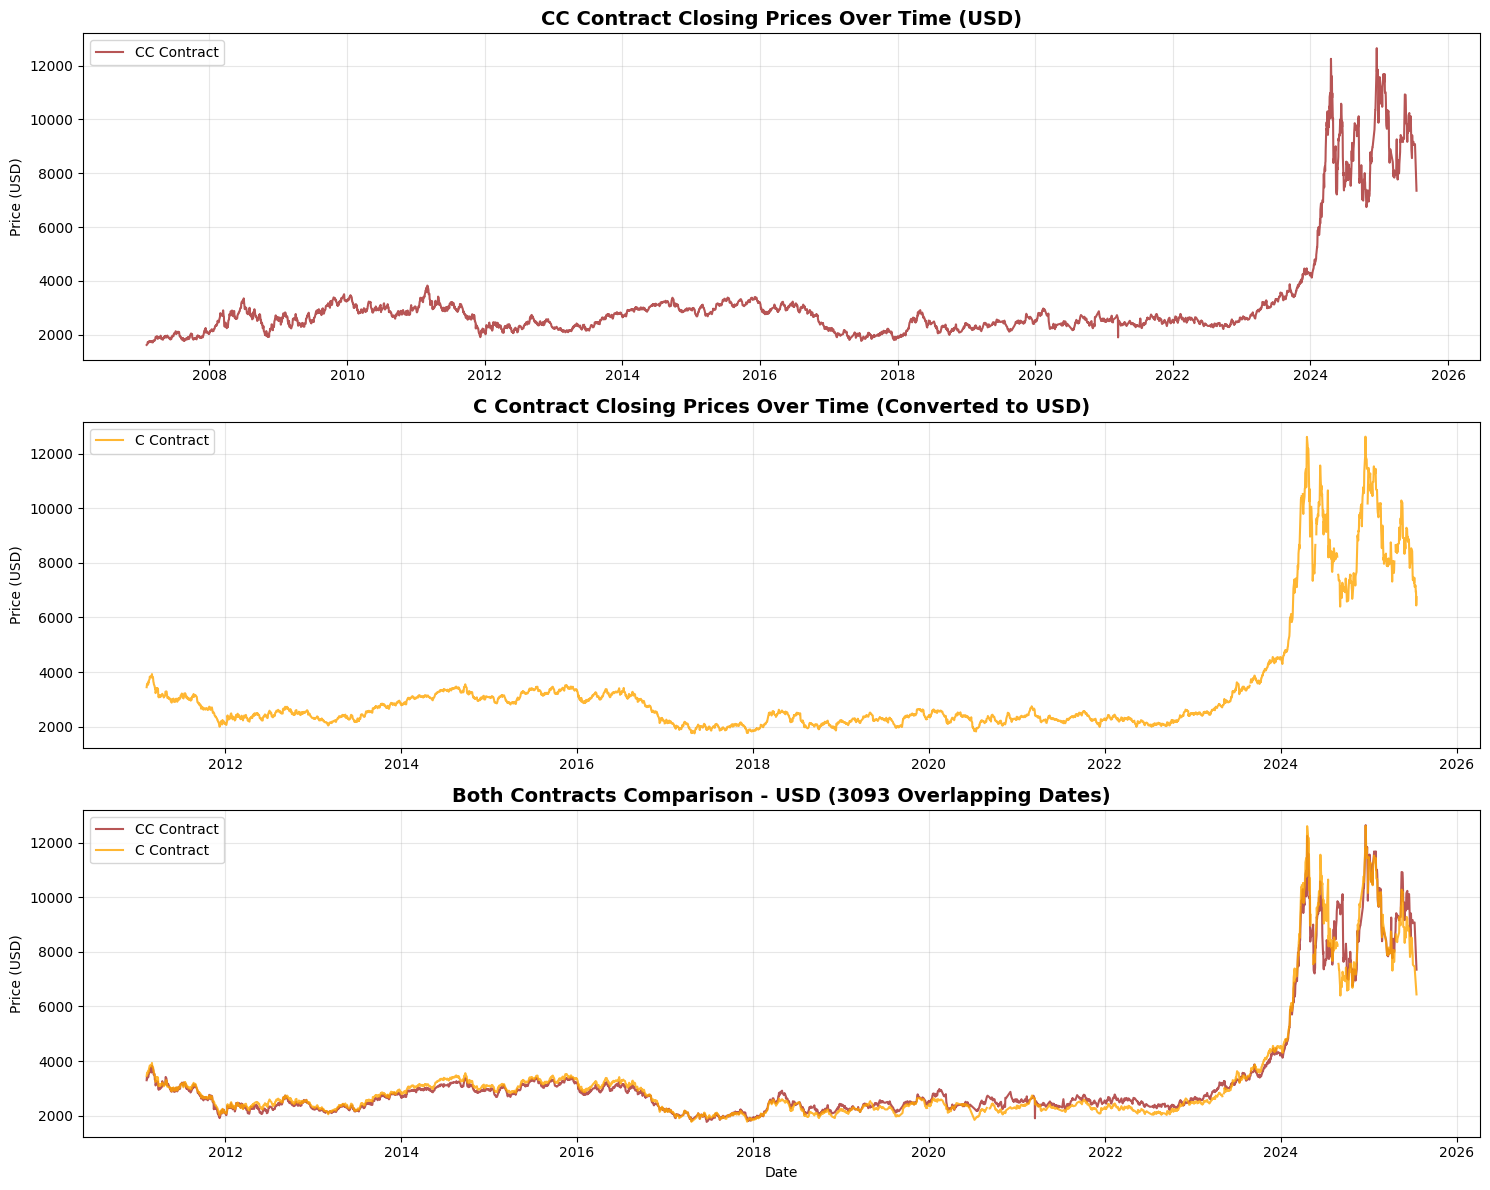

Overlapping dates: 3093


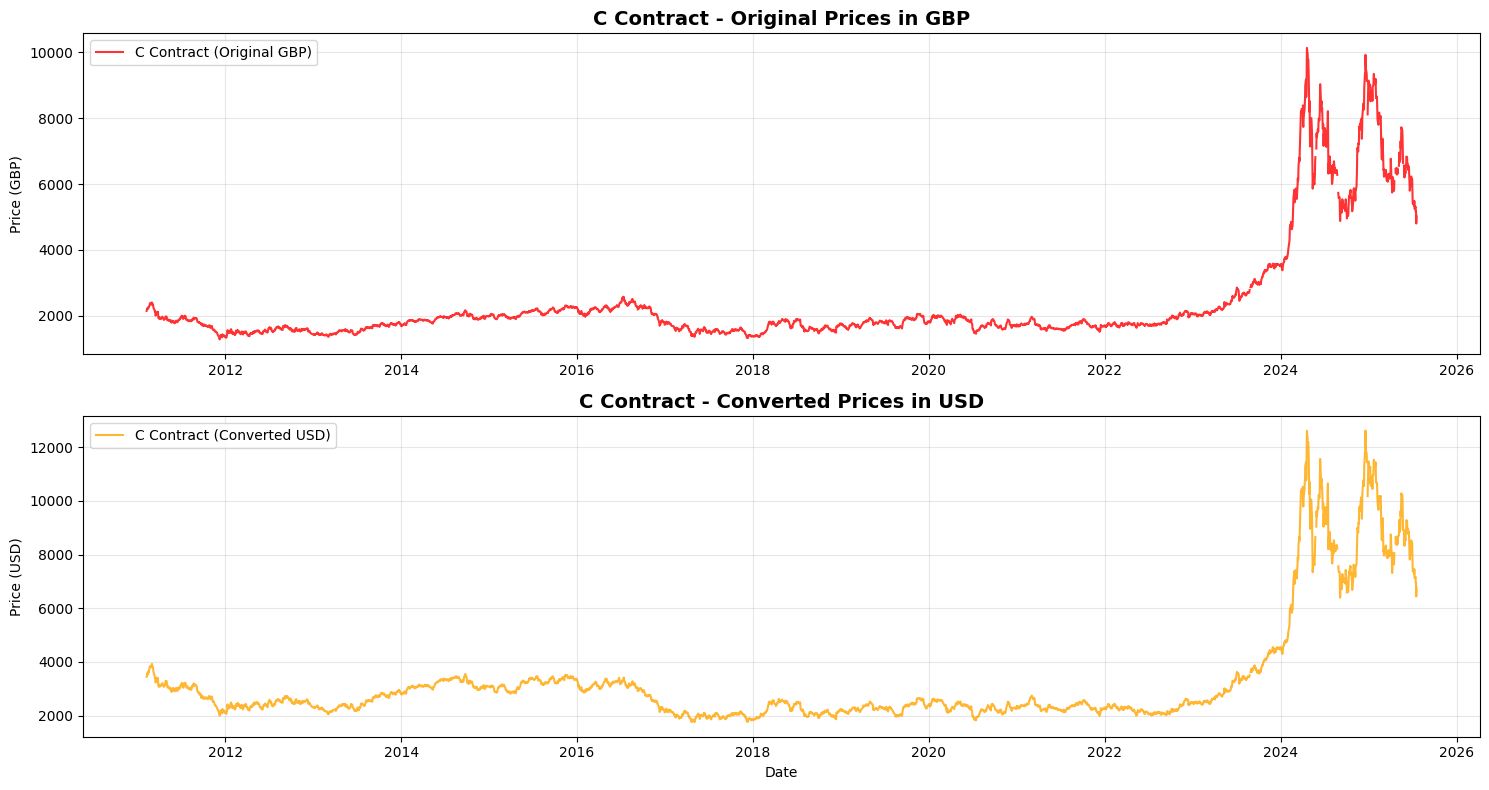

In [55]:
# Plot both closing price series with proper currency labels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Individual series
ax1.plot(cc_data['date'], cc_data['close'], label='CC Contract', color='brown', alpha=0.8)
ax1.set_title('CC Contract Closing Prices Over Time (USD)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (USD)')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(c_data['date'], c_data['close'], label='C Contract', color='orange', alpha=0.8)
ax2.set_title('C Contract Closing Prices Over Time (Converted to USD)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Price (USD)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Combined comparison (only overlapping dates)
cc_dates = set(cc_data['date'])
c_dates = set(c_data['date'])
common_dates = cc_dates.intersection(c_dates)

if common_dates:
    cc_common = cc_data[cc_data['date'].isin(common_dates)].sort_values('date')
    c_common = c_data[c_data['date'].isin(common_dates)].sort_values('date')
    
    ax3.plot(cc_common['date'], cc_common['close'], label='CC Contract', color='brown', alpha=0.8)
    ax3.plot(c_common['date'], c_common['close'], label='C Contract', color='orange', alpha=0.8)
    ax3.set_title(f'Both Contracts Comparison - USD ({len(common_dates)} Overlapping Dates)', fontsize=14, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No overlapping dates found', ha='center', va='center', transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Both Contracts Comparison - USD', fontsize=14, fontweight='bold')

ax3.set_ylabel('Price (USD)')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

print(f"Overlapping dates: {len(common_dates) if common_dates else 0}")

# Show original GBP vs converted USD for C contract
if 'close_original_gbp' in c_data.columns and not c_data['close_original_gbp'].isna().all():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    ax1.plot(c_data['date'], c_data['close_original_gbp'], label='C Contract (Original GBP)', color='red', alpha=0.8)
    ax1.set_title('C Contract - Original Prices in GBP', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (GBP)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(c_data['date'], c_data['close'], label='C Contract (Converted USD)', color='orange', alpha=0.8)
    ax2.set_title('C Contract - Converted Prices in USD', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Price (USD)')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## 3. Volume Analysis

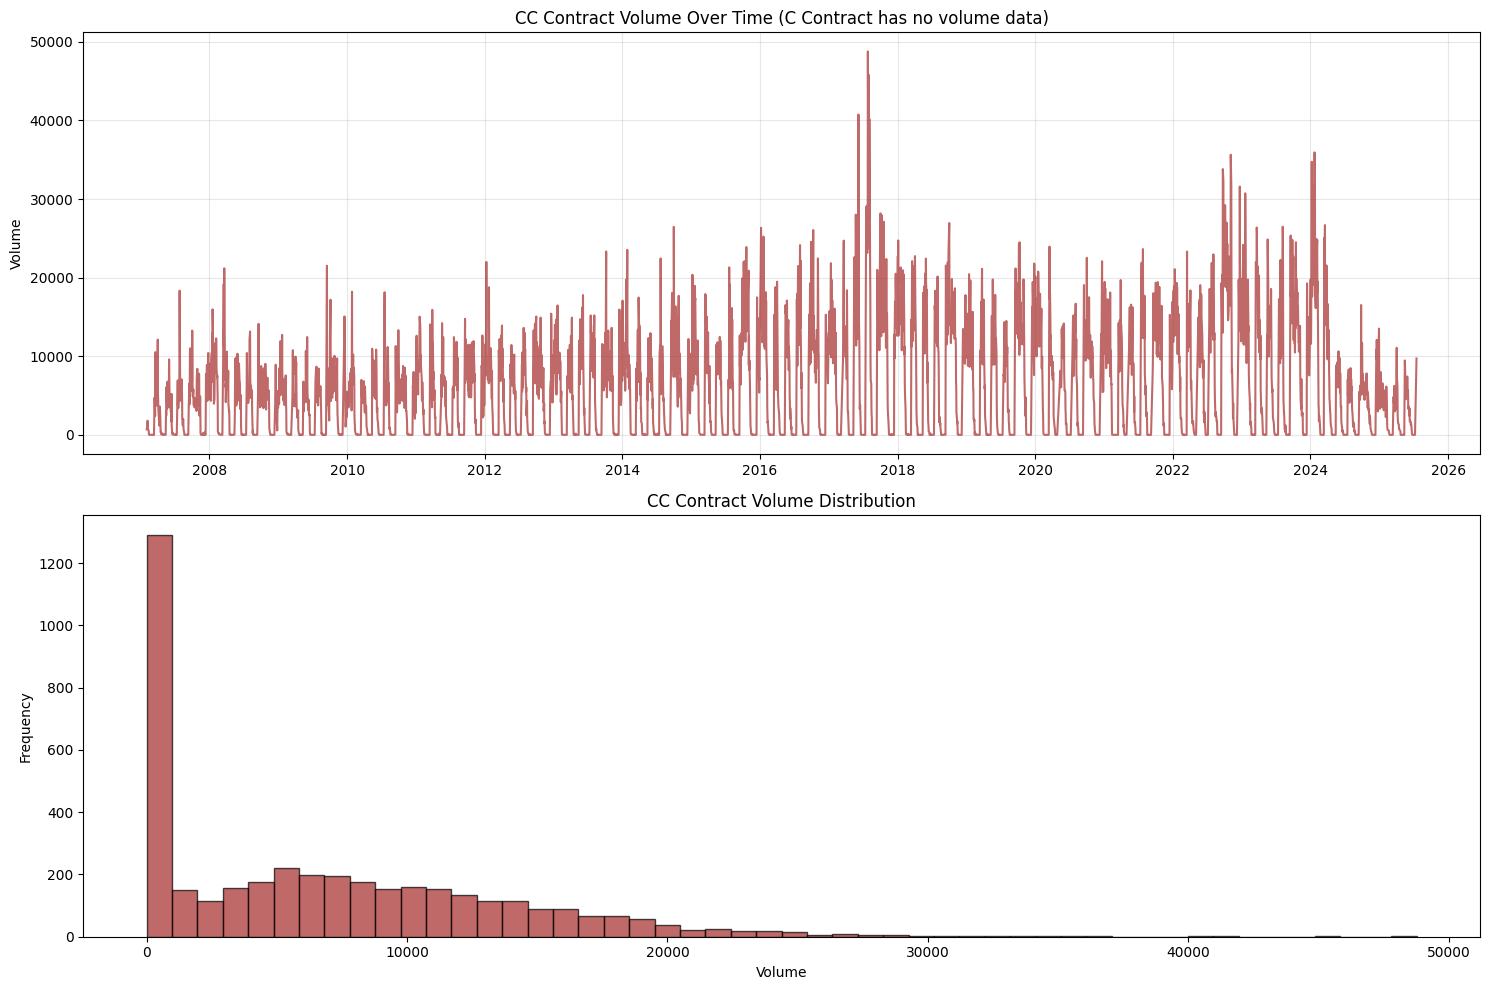

Note: Volume analysis only available for CC contract as C contract has no volume data


In [56]:
# Volume analysis (only CC contract has volume data)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Volume over time
ax1.plot(cc_data['date'], cc_data['VOLUME'], color='brown', alpha=0.7)
ax1.set_title('CC Contract Volume Over Time (C Contract has no volume data)')
ax1.set_ylabel('Volume')
ax1.grid(True, alpha=0.3)

# Volume distribution
ax2.hist(cc_data['VOLUME'], bins=50, alpha=0.7, color='brown', edgecolor='black')
ax2.set_title('CC Contract Volume Distribution')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Note: Volume analysis only available for CC contract as C contract has no volume data")

## 4. Price Returns Analysis

In [57]:
# Calculate daily returns
cc_data['returns'] = cc_data['close'].pct_change()
c_data['returns'] = c_data['close'].pct_change()

# Calculate log returns
cc_data['log_returns'] = np.log(cc_data['close'] / cc_data['close'].shift(1))
c_data['log_returns'] = np.log(c_data['close'] / c_data['close'].shift(1))

# Returns statistics
print("=== CC Contract Returns Statistics ===")
print(f"Mean Daily Return: {cc_data['returns'].mean():.4f}")
print(f"Daily Volatility: {cc_data['returns'].std():.4f}")
print(f"Annualized Volatility: {cc_data['returns'].std() * np.sqrt(252):.4f}")
print(f"Skewness: {cc_data['returns'].skew():.4f}")
print(f"Kurtosis: {cc_data['returns'].kurtosis():.4f}")

print("\n=== C Contract Returns Statistics ===")
print(f"Mean Daily Return: {c_data['returns'].mean():.4f}")
print(f"Daily Volatility: {c_data['returns'].std():.4f}")
print(f"Annualized Volatility: {c_data['returns'].std() * np.sqrt(252):.4f}")
print(f"Skewness: {c_data['returns'].skew():.4f}")
print(f"Kurtosis: {c_data['returns'].kurtosis():.4f}")

=== CC Contract Returns Statistics ===
Mean Daily Return: 0.0007
Daily Volatility: 0.0243
Annualized Volatility: 0.3859
Skewness: -0.0055
Kurtosis: 17.9168

=== C Contract Returns Statistics ===
Mean Daily Return: 0.0004
Daily Volatility: 0.0195
Annualized Volatility: 0.3093
Skewness: -0.4089
Kurtosis: 10.1576


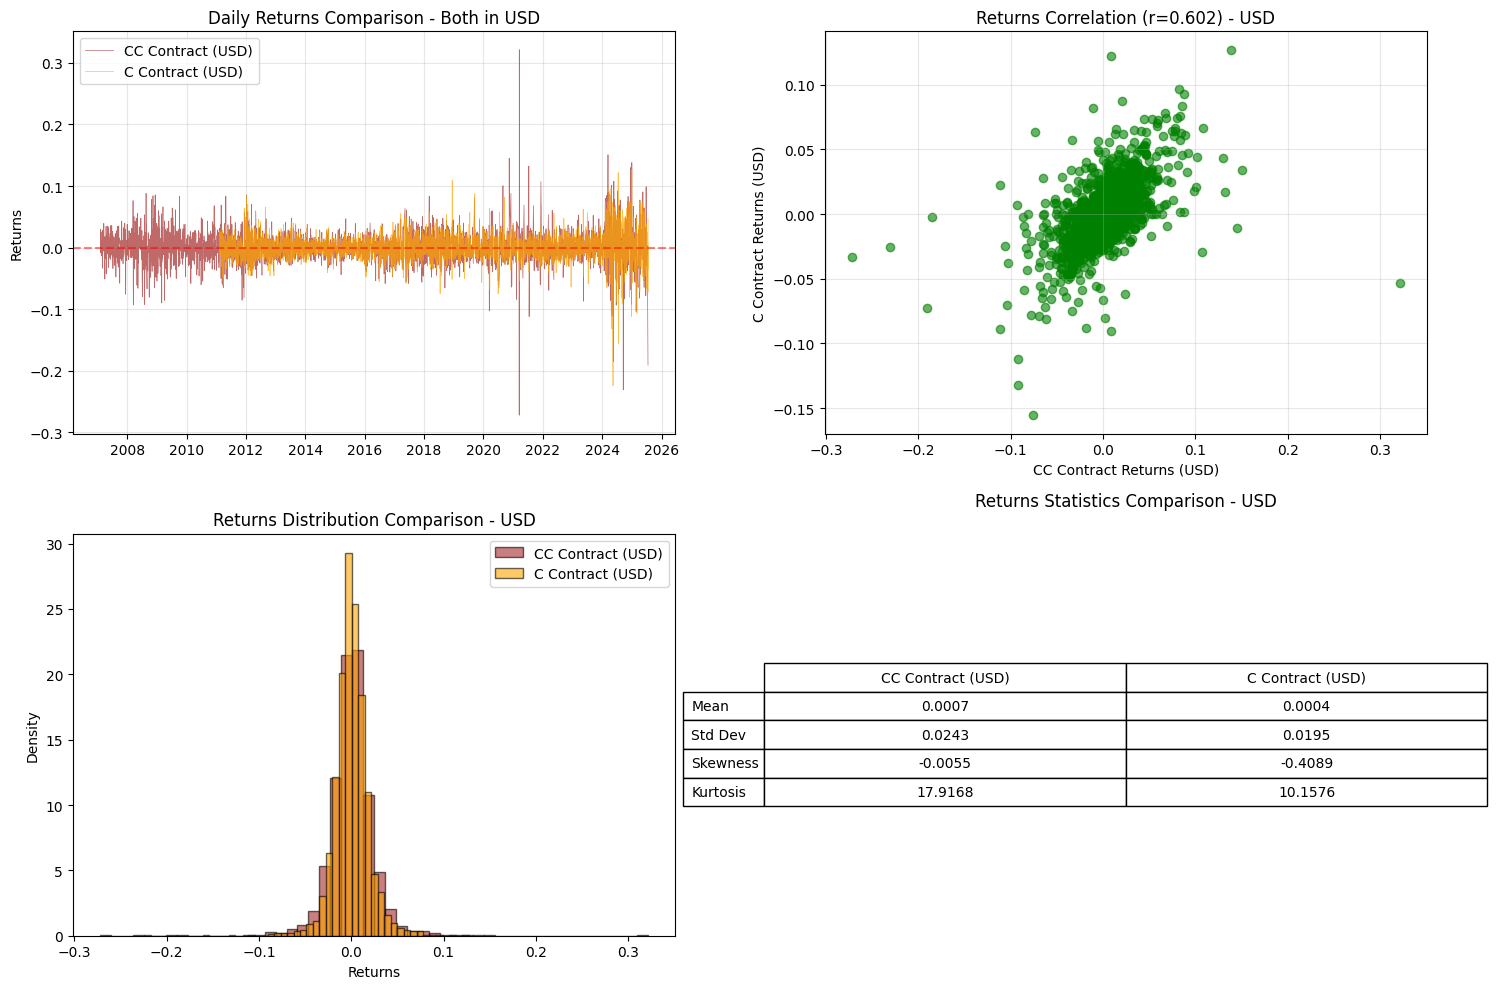

In [58]:
# Plot returns comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Returns over time - combined
ax1.plot(cc_data['date'], cc_data['returns'], color='brown', alpha=0.7, linewidth=0.5, label='CC Contract (USD)')
ax1.plot(c_data['date'], c_data['returns'], color='orange', alpha=0.7, linewidth=0.5, label='C Contract (USD)')
ax1.set_title('Daily Returns Comparison - Both in USD')
ax1.set_ylabel('Returns')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.legend()

# Returns correlation scatter (if overlapping data exists)
if len(set(cc_data['date']).intersection(set(c_data['date']))) > 0:
    returns_merged = pd.merge(cc_data[['date', 'returns']], c_data[['date', 'returns']], 
                             on='date', suffixes=('_cc', '_c'))
    returns_corr = returns_merged['returns_cc'].corr(returns_merged['returns_c'])
    
    ax2.scatter(returns_merged['returns_cc'], returns_merged['returns_c'], alpha=0.6, color='green')
    ax2.set_xlabel('CC Contract Returns (USD)')
    ax2.set_ylabel('C Contract Returns (USD)')
    ax2.set_title(f'Returns Correlation (r={returns_corr:.3f}) - USD')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No overlapping data', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Returns Correlation - USD')

# Returns distributions - combined
ax3.hist(cc_data['returns'].dropna(), bins=50, alpha=0.6, color='brown', edgecolor='black', 
         density=True, label='CC Contract (USD)')
ax3.hist(c_data['returns'].dropna(), bins=50, alpha=0.6, color='orange', edgecolor='black', 
         density=True, label='C Contract (USD)')
ax3.set_title('Returns Distribution Comparison - USD')
ax3.set_xlabel('Returns')
ax3.set_ylabel('Density')
ax3.legend()

# Returns statistics comparison
stats_data = pd.DataFrame({
    'CC Contract (USD)': [cc_data['returns'].mean(), cc_data['returns'].std(), 
                   cc_data['returns'].skew(), cc_data['returns'].kurtosis()],
    'C Contract (USD)': [c_data['returns'].mean(), c_data['returns'].std(), 
                  c_data['returns'].skew(), c_data['returns'].kurtosis()]
}, index=['Mean', 'Std Dev', 'Skewness', 'Kurtosis'])

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=stats_data.round(4).values,
                 rowLabels=stats_data.index,
                 colLabels=stats_data.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Returns Statistics Comparison - USD', pad=20)

plt.tight_layout()
plt.show()

## 5. Volatility Analysis

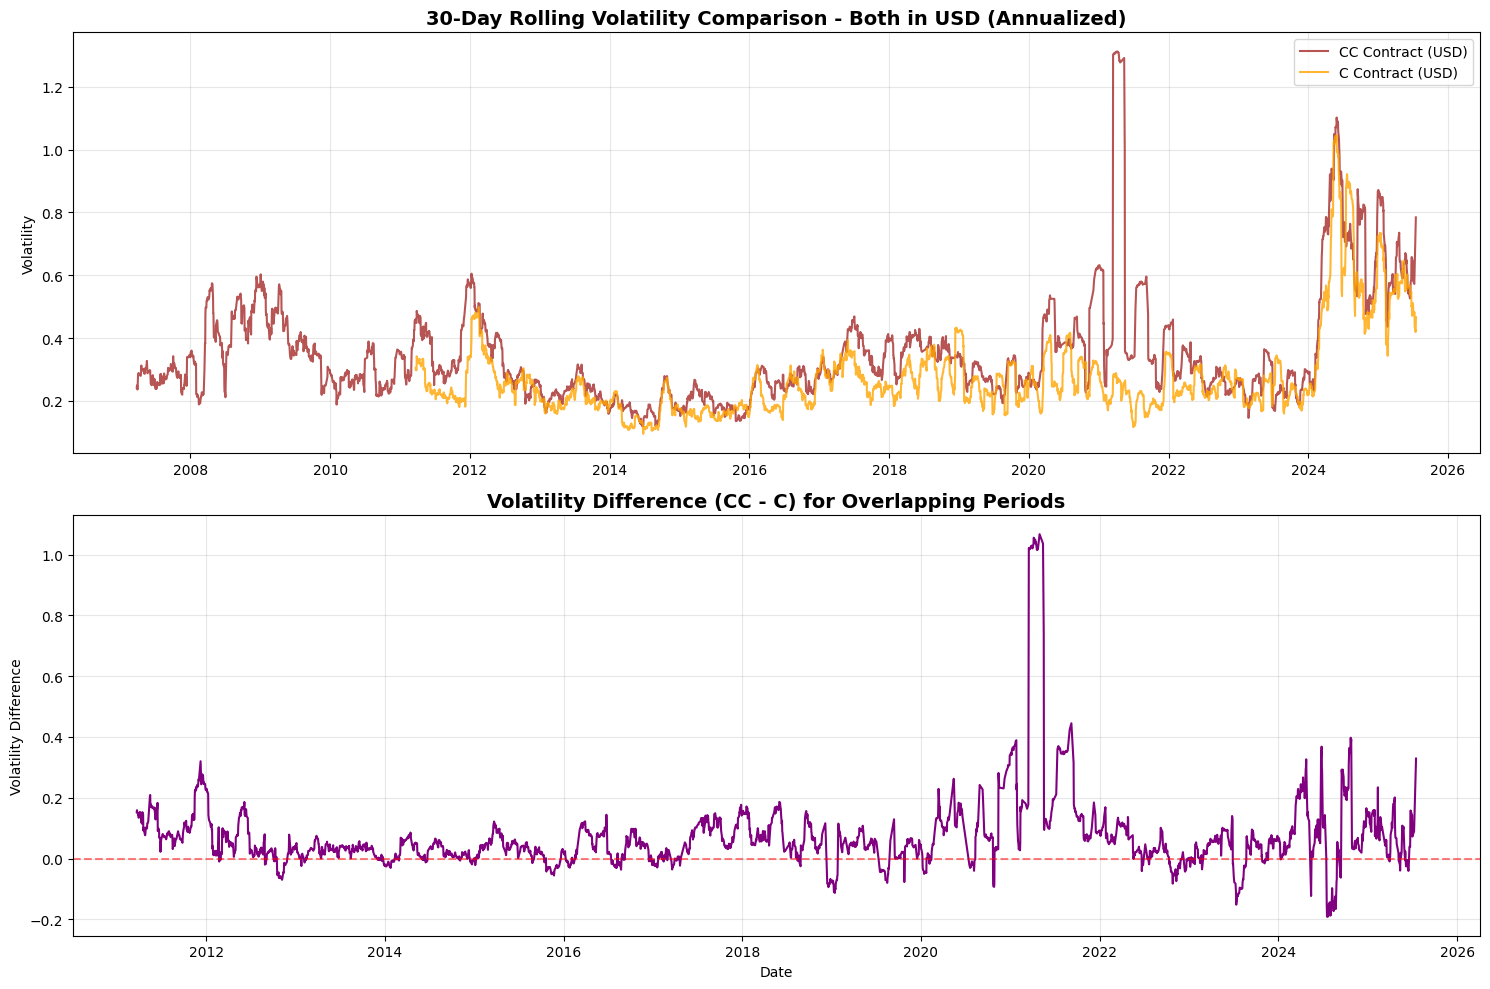

In [59]:
# Calculate rolling volatility (30-day window)
cc_data['rolling_vol'] = cc_data['returns'].rolling(window=30).std() * np.sqrt(252)
c_data['rolling_vol'] = c_data['returns'].rolling(window=30).std() * np.sqrt(252)

# Plot both volatilities on same graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Combined volatility comparison
ax1.plot(cc_data['date'], cc_data['rolling_vol'], color='brown', linewidth=1.5, label='CC Contract (USD)', alpha=0.8)
ax1.plot(c_data['date'], c_data['rolling_vol'], color='orange', linewidth=1.5, label='C Contract (USD)', alpha=0.8)
ax1.set_title('30-Day Rolling Volatility Comparison - Both in USD (Annualized)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Volatility')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Volatility difference (where overlapping)
if len(set(cc_data['date']).intersection(set(c_data['date']))) > 30:
    # Merge for overlapping periods
    vol_merged = pd.merge(cc_data[['date', 'rolling_vol']], c_data[['date', 'rolling_vol']], 
                         on='date', suffixes=('_cc', '_c'))
    vol_diff = vol_merged['rolling_vol_cc'] - vol_merged['rolling_vol_c']
    
    ax2.plot(vol_merged['date'], vol_diff, color='purple', linewidth=1.5)
    ax2.set_title('Volatility Difference (CC - C) for Overlapping Periods', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volatility Difference')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'Insufficient overlapping data for volatility difference analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Volatility Difference Analysis', fontsize=14, fontweight='bold')

ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

## 6. Seasonality Analysis

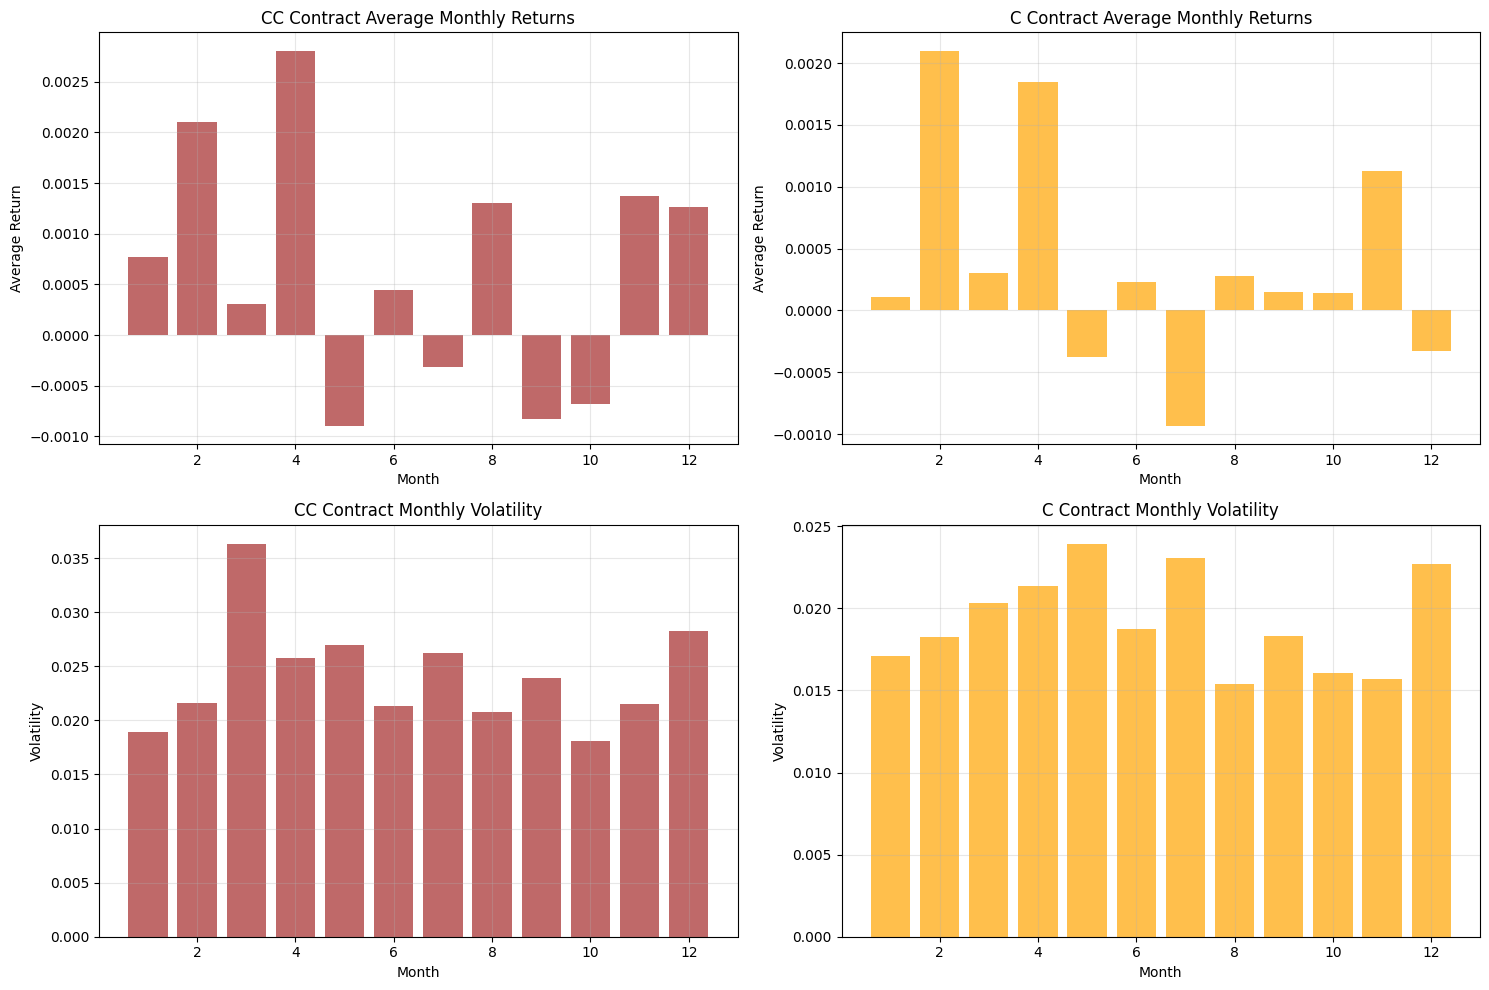

In [60]:
# Add time components
cc_data['year'] = cc_data['date'].dt.year
cc_data['month'] = cc_data['date'].dt.month
cc_data['quarter'] = cc_data['date'].dt.quarter
cc_data['dayofweek'] = cc_data['date'].dt.dayofweek

c_data['year'] = c_data['date'].dt.year
c_data['month'] = c_data['date'].dt.month
c_data['quarter'] = c_data['date'].dt.quarter
c_data['dayofweek'] = c_data['date'].dt.dayofweek

# Monthly seasonality
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Monthly returns
cc_monthly = cc_data.groupby('month')['returns'].mean()
c_monthly = c_data.groupby('month')['returns'].mean()

ax1.bar(cc_monthly.index, cc_monthly.values, color='brown', alpha=0.7)
ax1.set_title('CC Contract Average Monthly Returns')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Return')
ax1.grid(True, alpha=0.3)

ax2.bar(c_monthly.index, c_monthly.values, color='orange', alpha=0.7)
ax2.set_title('C Contract Average Monthly Returns')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Return')
ax2.grid(True, alpha=0.3)

# Monthly volatility
cc_monthly_vol = cc_data.groupby('month')['returns'].std()
c_monthly_vol = c_data.groupby('month')['returns'].std()

ax3.bar(cc_monthly_vol.index, cc_monthly_vol.values, color='brown', alpha=0.7)
ax3.set_title('CC Contract Monthly Volatility')
ax3.set_xlabel('Month')
ax3.set_ylabel('Volatility')
ax3.grid(True, alpha=0.3)

ax4.bar(c_monthly_vol.index, c_monthly_vol.values, color='orange', alpha=0.7)
ax4.set_title('C Contract Monthly Volatility')
ax4.set_xlabel('Month')
ax4.set_ylabel('Volatility')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

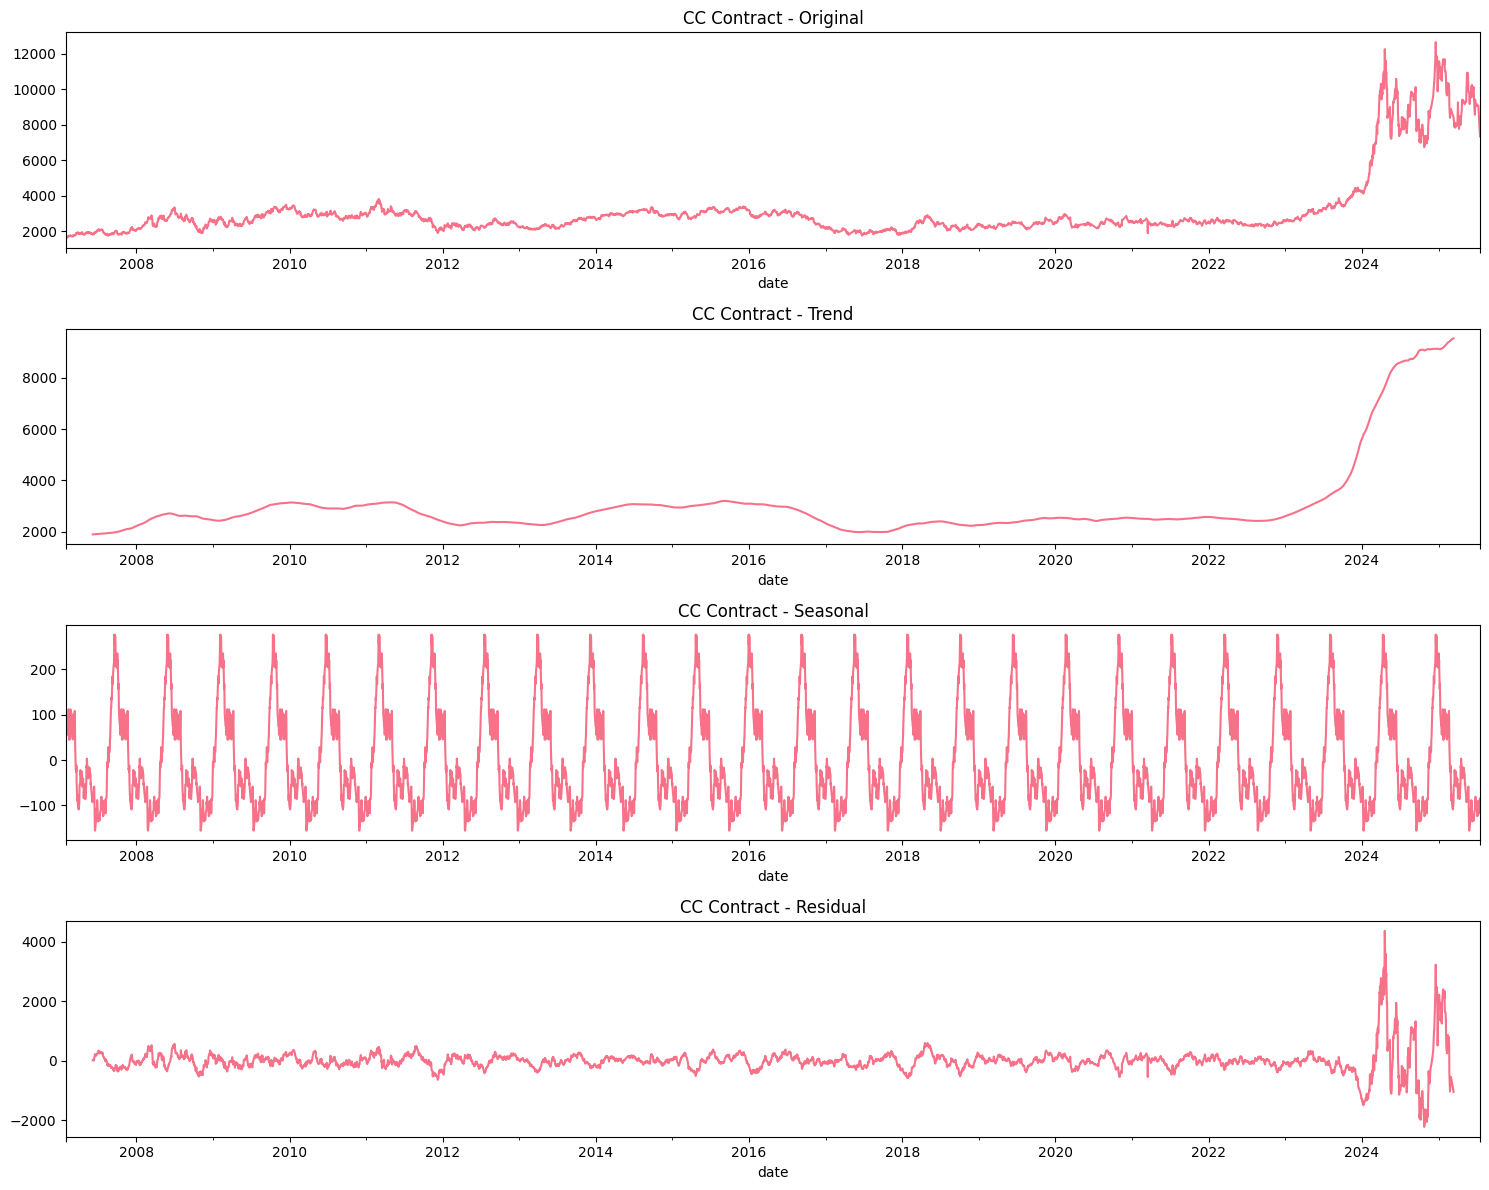

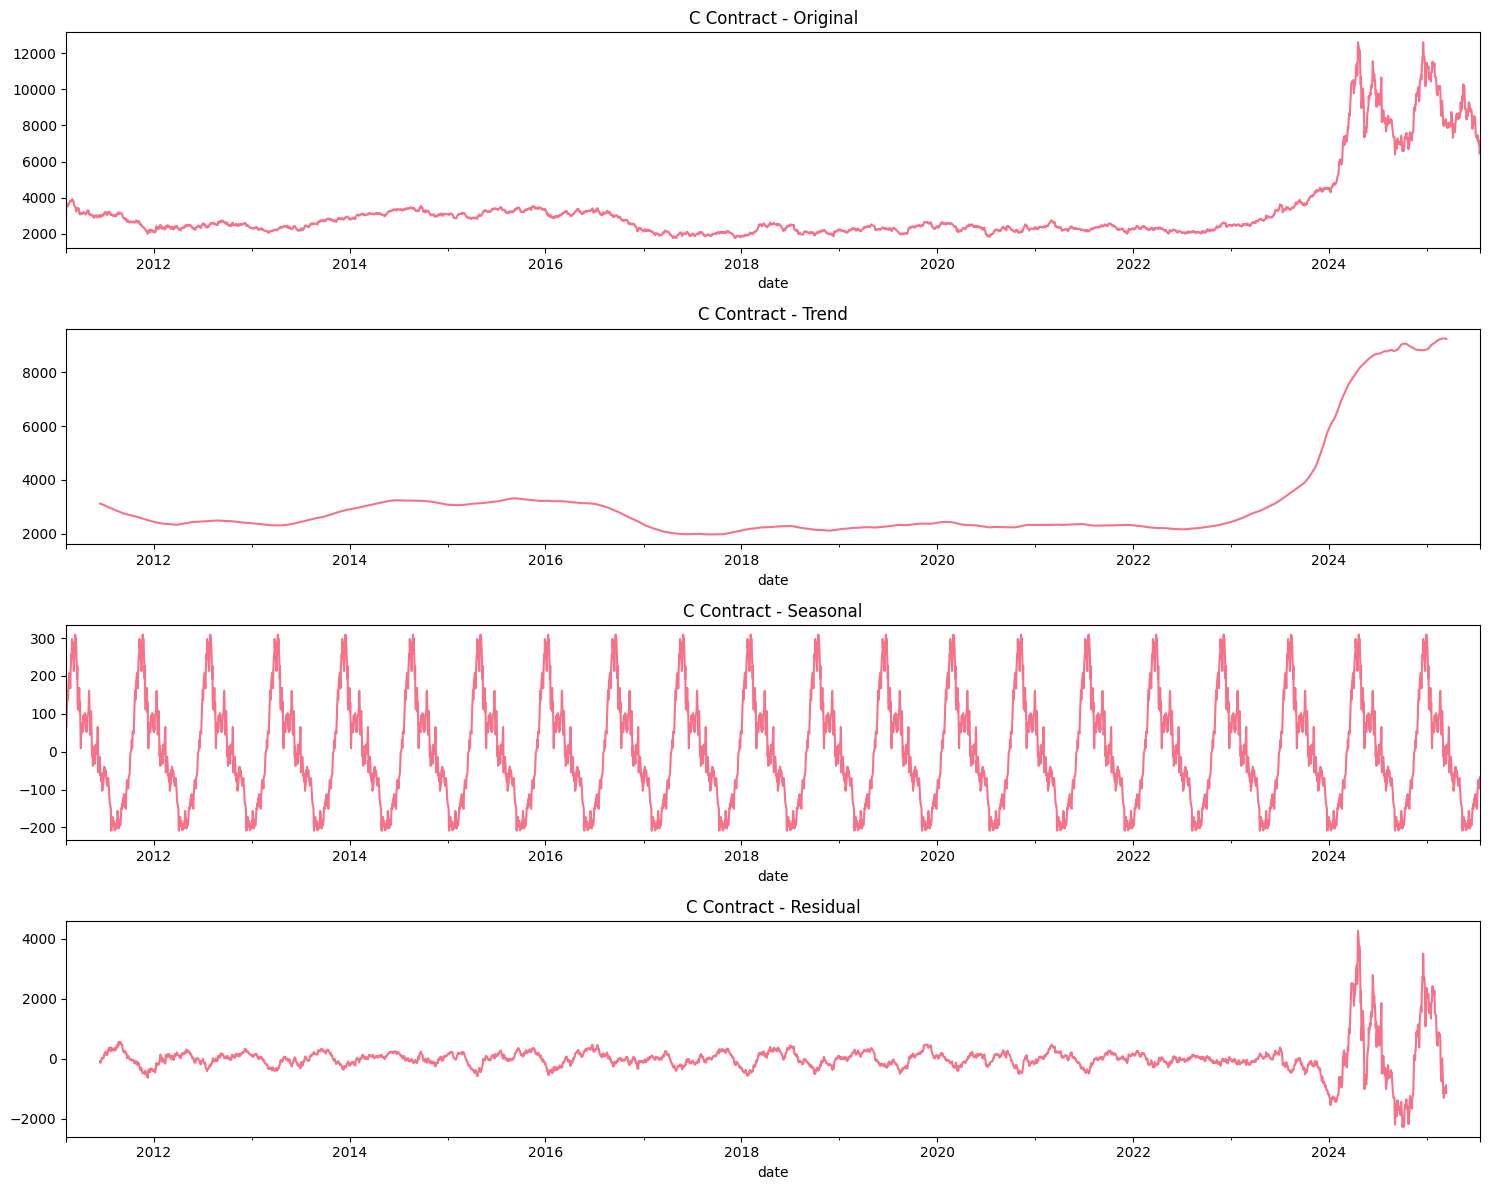

In [61]:
# Seasonal decomposition (if enough data)
def perform_seasonal_decomposition(data, title_prefix):
    if len(data) > 104:  # Need at least 2 years of weekly data
        try:
            # Set date as index for decomposition
            ts_data = data.set_index('date')['close'].asfreq('D').interpolate()
            
            # Perform seasonal decomposition
            decomposition = seasonal_decompose(ts_data, model='additive', period=252)  # Annual cycle
            
            # Plot decomposition
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            
            decomposition.observed.plot(ax=axes[0], title=f'{title_prefix} - Original')
            decomposition.trend.plot(ax=axes[1], title=f'{title_prefix} - Trend')
            decomposition.seasonal.plot(ax=axes[2], title=f'{title_prefix} - Seasonal')
            decomposition.resid.plot(ax=axes[3], title=f'{title_prefix} - Residual')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not perform seasonal decomposition for {title_prefix}: {e}")
    else:
        print(f"Not enough data for seasonal decomposition of {title_prefix}")

# Perform seasonal decomposition for both contracts
perform_seasonal_decomposition(cc_data, 'CC Contract')
perform_seasonal_decomposition(c_data, 'C Contract')

## 7. Correlation Analysis

Number of overlapping observations: 3093

Price Correlation (USD): 0.9883
Returns Correlation (USD): 0.6024

Note: Volume correlation not available (C contract has no volume data)
Note: Both contracts now converted to USD for proper comparison


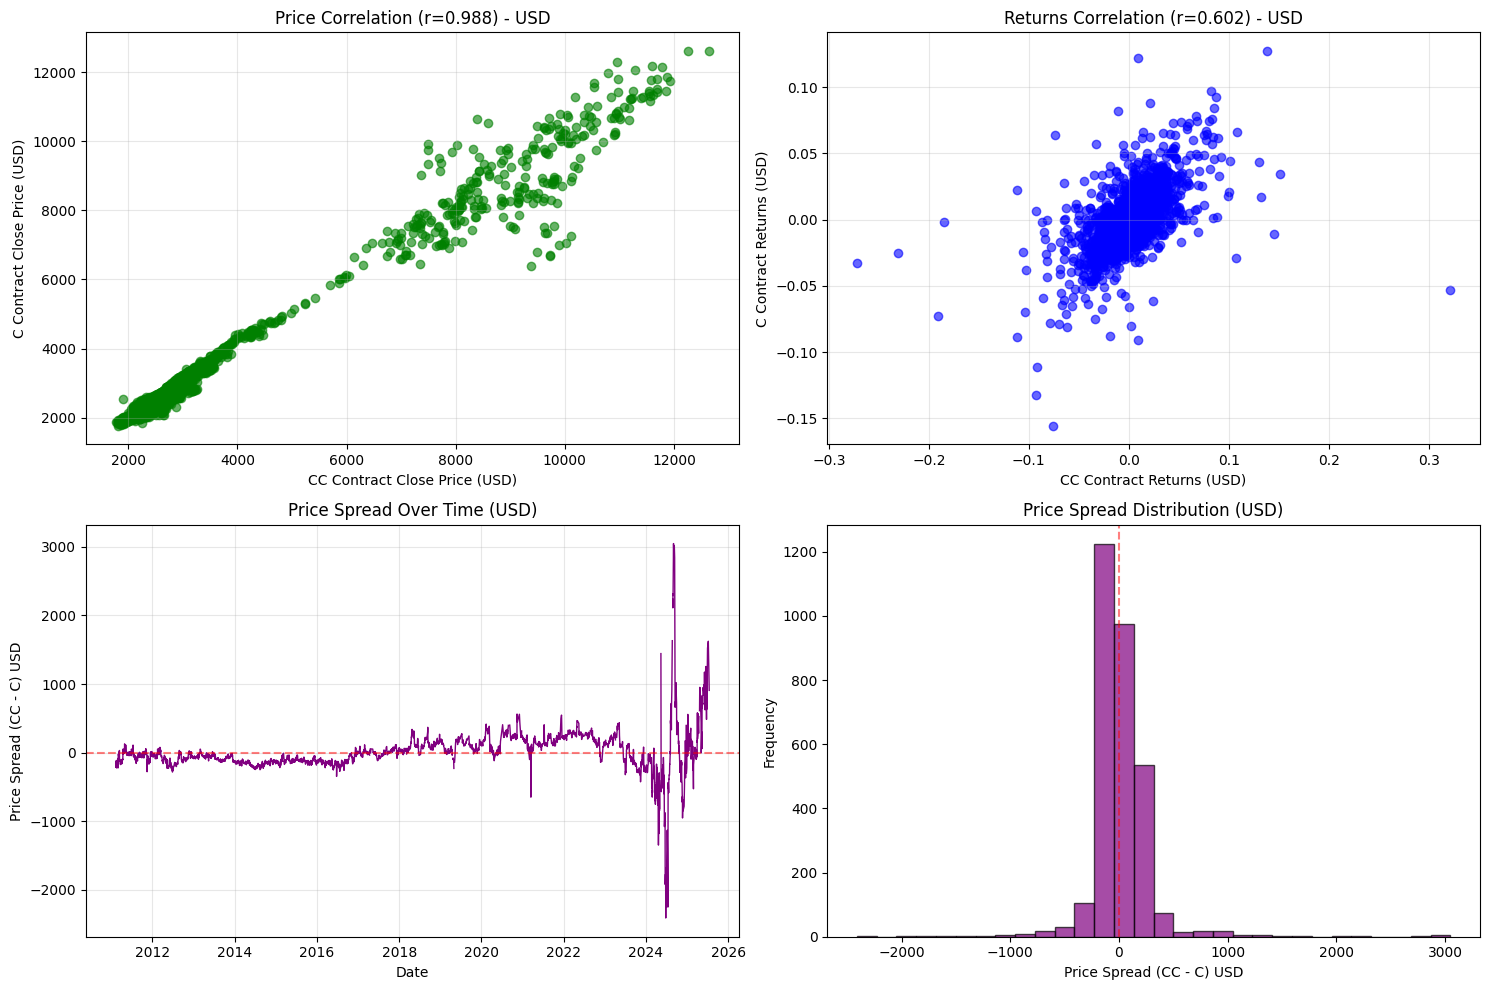


=== Price Spread Statistics (USD) ===
Mean spread: $8.10
Spread std dev: $303.12
Spread min: $-2411.28
Spread max: $3048.61


In [62]:
# Merge datasets on common dates for correlation analysis
if common_dates:
    # Only merge available columns (C contract doesn't have VOLUME)
    merged_data = pd.merge(cc_data[['date', 'close', 'returns']], 
                          c_data[['date', 'close', 'returns']], 
                          on='date', suffixes=('_cc', '_c'))
    
    print(f"Number of overlapping observations: {len(merged_data)}")
    
    # Calculate correlations
    price_corr = merged_data['close_cc'].corr(merged_data['close_c'])
    returns_corr = merged_data['returns_cc'].corr(merged_data['returns_c'])
    
    print(f"\nPrice Correlation (USD): {price_corr:.4f}")
    print(f"Returns Correlation (USD): {returns_corr:.4f}")
    print("\nNote: Volume correlation not available (C contract has no volume data)")
    print("Note: Both contracts now converted to USD for proper comparison")
    
    # Plot correlations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Price correlation scatter
    ax1.scatter(merged_data['close_cc'], merged_data['close_c'], alpha=0.6, color='green')
    ax1.set_xlabel('CC Contract Close Price (USD)')
    ax1.set_ylabel('C Contract Close Price (USD)')
    ax1.set_title(f'Price Correlation (r={price_corr:.3f}) - USD')
    ax1.grid(True, alpha=0.3)
    
    # Returns correlation scatter
    ax2.scatter(merged_data['returns_cc'], merged_data['returns_c'], alpha=0.6, color='blue')
    ax2.set_xlabel('CC Contract Returns (USD)')
    ax2.set_ylabel('C Contract Returns (USD)')
    ax2.set_title(f'Returns Correlation (r={returns_corr:.3f}) - USD')
    ax2.grid(True, alpha=0.3)
    
    # Price spread over time
    spread = merged_data['close_cc'] - merged_data['close_c']
    ax3.plot(merged_data['date'], spread, color='purple', linewidth=1)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Price Spread (CC - C) USD')
    ax3.set_title('Price Spread Over Time (USD)')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Spread distribution
    ax4.hist(spread, bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax4.set_xlabel('Price Spread (CC - C) USD')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Price Spread Distribution (USD)')
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Additional spread statistics
    print(f"\n=== Price Spread Statistics (USD) ===")
    print(f"Mean spread: ${spread.mean():.2f}")
    print(f"Spread std dev: ${spread.std():.2f}")
    print(f"Spread min: ${spread.min():.2f}")
    print(f"Spread max: ${spread.max():.2f}")
    
else:
    print("No overlapping dates found between contracts for correlation analysis")
    
    # Show separate time periods
    print(f"\nCC Contract period: {cc_data['date'].min()} to {cc_data['date'].max()}")
    print(f"C Contract period: {c_data['date'].min()} to {c_data['date'].max()}")

## 8. Statistical Tests and Analysis

In [63]:
# Test for stationarity using Augmented Dickey-Fuller test
def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f'\n{title}')
    print('='*50)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Reject null hypothesis - Series is stationary")
    else:
        print("Result: Fail to reject null hypothesis - Series is non-stationary")

# Test both price series and returns
adf_test(cc_data['close'], 'CC Contract - Price Series Stationarity Test')
adf_test(cc_data['returns'], 'CC Contract - Returns Series Stationarity Test')
adf_test(c_data['close'], 'C Contract - Price Series Stationarity Test')
adf_test(c_data['returns'], 'C Contract - Returns Series Stationarity Test')


CC Contract - Price Series Stationarity Test
ADF Statistic: -1.629581
p-value: 0.467710
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Result: Fail to reject null hypothesis - Series is non-stationary

CC Contract - Returns Series Stationarity Test
ADF Statistic: -67.945246
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Result: Reject null hypothesis - Series is stationary

C Contract - Price Series Stationarity Test
ADF Statistic: -1.704580
p-value: 0.428755
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Result: Fail to reject null hypothesis - Series is non-stationary

C Contract - Returns Series Stationarity Test
ADF Statistic: -24.754001
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Result: Reject null hypothesis - Series is stationary


In [64]:
# Normality tests for returns
def normality_test(series, title):
    series_clean = series.dropna()
    shapiro_stat, shapiro_p = stats.shapiro(series_clean[:5000])  # Limit to 5000 obs for Shapiro-Wilk
    jb_stat, jb_p = stats.jarque_bera(series_clean)
    
    print(f'\n{title}')
    print('='*50)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.6f}, p-value={shapiro_p:.6f}')
    print(f'Jarque-Bera Test: Statistic={jb_stat:.6f}, p-value={jb_p:.6f}')
    
    if shapiro_p > 0.05 and jb_p > 0.05:
        print("Result: Returns appear to be normally distributed")
    else:
        print("Result: Returns are NOT normally distributed")

normality_test(cc_data['returns'], 'CC Contract - Returns Normality Test')
normality_test(c_data['returns'], 'C Contract - Returns Normality Test')


CC Contract - Returns Normality Test
Shapiro-Wilk Test: Statistic=0.890392, p-value=0.000000
Jarque-Bera Test: Statistic=53974.538490, p-value=0.000000
Result: Returns are NOT normally distributed

C Contract - Returns Normality Test
Shapiro-Wilk Test: Statistic=0.917747, p-value=0.000000
Jarque-Bera Test: Statistic=16056.697085, p-value=0.000000
Result: Returns are NOT normally distributed


## 9. Summary and Key Insights

In [65]:
# Summary statistics table
summary_stats = pd.DataFrame({
    'CC Contract': [
        len(cc_data),
        cc_data['date'].min().strftime('%Y-%m-%d'),
        cc_data['date'].max().strftime('%Y-%m-%d'),
        f"{cc_data['close'].mean():.2f}",
        f"{cc_data['close'].std():.2f}",
        f"{cc_data['returns'].mean()*252:.4f}",
        f"{cc_data['returns'].std()*np.sqrt(252):.4f}",
        f"{cc_data['VOLUME'].mean():.0f}",
        "Full OHLCV"
    ],
    'C Contract': [
        len(c_data),
        c_data['date'].min().strftime('%Y-%m-%d'),
        c_data['date'].max().strftime('%Y-%m-%d'),
        f"{c_data['close'].mean():.2f}",
        f"{c_data['close'].std():.2f}",
        f"{c_data['returns'].mean()*252:.4f}",
        f"{c_data['returns'].std()*np.sqrt(252):.4f}",
        "N/A (no volume data)",
        "Close only"
    ]
}, index=[
    'Observations',
    'Start Date',
    'End Date', 
    'Mean Price',
    'Price Std Dev',
    'Annualized Return',
    'Annualized Volatility',
    'Average Volume',
    'Data Type'
])

print("=== CACAO CONTRACTS SUMMARY ===")
print(summary_stats)

print("\n=== KEY INSIGHTS ===")
print(f"• CC Contract: {len(cc_data)} observations from {cc_data['date'].min().strftime('%Y-%m-%d')} to {cc_data['date'].max().strftime('%Y-%m-%d')}")
print(f"• C Contract: {len(c_data)} observations from {c_data['date'].min().strftime('%Y-%m-%d')} to {c_data['date'].max().strftime('%Y-%m-%d')}")

if common_dates:
    print(f"• {len(common_dates)} overlapping trading days between contracts")
    print(f"• Price correlation: {price_corr:.3f}")
    print(f"• Returns correlation: {returns_corr:.3f}")
else:
    print("• No overlapping trading days between contracts")

print(f"• CC Contract annualized volatility: {cc_data['returns'].std() * np.sqrt(252):.1%}")
print(f"• C Contract annualized volatility: {c_data['returns'].std() * np.sqrt(252):.1%}")
print("• CC contract provides full OHLCV data while C contract only has close prices")
print("• Volume analysis is only possible for CC contract")
print("• OHLC pattern analysis (daily range, body size) only available for CC contract")

=== CACAO CONTRACTS SUMMARY ===
                      CC Contract            C Contract
Observations                 4047                  3723
Start Date             2007-02-02            2011-02-09
End Date               2025-07-17            2025-07-18
Mean Price                3116.51               3239.01
Price Std Dev             1782.36               1982.50
Annualized Return          0.1691                0.0936
Annualized Volatility      0.3859                0.3093
Average Volume               6721  N/A (no volume data)
Data Type              Full OHLCV            Close only

=== KEY INSIGHTS ===
• CC Contract: 4047 observations from 2007-02-02 to 2025-07-17
• C Contract: 3723 observations from 2011-02-09 to 2025-07-18
• 3093 overlapping trading days between contracts
• Price correlation: 0.988
• Returns correlation: 0.602
• CC Contract annualized volatility: 38.6%
• C Contract annualized volatility: 30.9%
• CC contract provides full OHLCV data while C contract only has close